In [85]:
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [86]:
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

In [87]:
import numpy as np
import pandas as pd
import joblib
import os
import gc
from sklearn.preprocessing import LabelEncoder

# =========================================
# 1. CẤU HÌNH VÀ HÀM HỖ TRỢ
# =========================================
INPUT_MODEL_DIR = "processed_data_final_v1"
TEST_DATA_PATH = "../data_clear2/val_split.csv"

SEQ_LEN = 10
GROUP_ID_COL = 'card1'
TIME_COL = 'TransactionDT'
TARGET_COL = 'isFraud'

def create_sequences_with_label(data, labels, seq_len):
    seq_data = []
    seq_labels = []
    if len(data) >= seq_len:
        for i in range(len(data) - seq_len + 1):
            window = data[i:(i + seq_len)]
            seq_data.append(window)
            seq_labels.append(labels[i + seq_len - 1])
    return np.array(seq_data), np.array(seq_labels)

def create_synced_data(df, target_col, group_col, time_col, seq_len, feature_cols):
    print(f"👉 Đang xử lý nhóm theo '{group_col}'...")
    # Chỉ lấy đúng các cột feature thực sự
    df_features = df[feature_cols].copy()
    
    # Thêm metadata để xử lý
    df_features['__GROUP__'] = df[group_col].values
    df_features['__TIME__'] = df[time_col].values
    df_features['__LABEL__'] = df[target_col].values

    grouped = df_features.groupby('__GROUP__')
    
    all_X = []
    all_y = []
    count = 0
    for _, group_df in grouped:
        group_df_sorted = group_df.sort_values(by='__TIME__')
        
        # Lấy đúng feature_cols để tạo chuỗi
        feature_data = group_df_sorted[feature_cols].values.astype(np.float32)
        label_data = group_df_sorted['__LABEL__'].values.astype(int)
        
        X_seq, y_seq = create_sequences_with_label(feature_data, label_data, seq_len)
        if len(X_seq) > 0:
            all_X.append(X_seq)
            all_y.append(y_seq)
        count += 1
        if count % 5000 == 0: print(f"   - Đã xử lý {count} nhóm...", end='\r')
        
    print(f"\n✅ Đã xử lý xong {count} nhóm.")
    X_final = np.concatenate(all_X, axis=0) if all_X else np.array([])
    y_final = np.concatenate(all_y, axis=0) if all_y else np.array([])
    return X_final, y_final

# =========================================
# 2. TẢI CẤU HÌNH
# =========================================
print("🚀 BẮT ĐẦU XỬ LÝ TẬP TEST (FIX LỖI 40 FEATURE)")
try:
    scaler = joblib.load(os.path.join(INPUT_MODEL_DIR, 'scaler_v1.joblib'))
    # Load danh sách feature gốc (có thể là 40)
    loaded_features = joblib.load(os.path.join(INPUT_MODEL_DIR, 'final_feature_list.joblib'))
    
    # === FIX QUAN TRỌNG: LỌC BỎ CÁC CỘT ID/TIME/TARGET ===
    final_features = [c for c in loaded_features if c not in [GROUP_ID_COL, TIME_COL, TARGET_COL]]
    print(f"   -> Danh sách gốc: {len(loaded_features)} đặc trưng.")
    print(f"   -> Sau khi lọc ID/Time: {len(final_features)} đặc trưng (Kỳ vọng: 38).")

    enc_path = os.path.join(INPUT_MODEL_DIR, 'label_encoders.joblib')
    label_encoders = joblib.load(enc_path) if os.path.exists(enc_path) else {}

except Exception as e:
    print(f"\n❌ LỖI TẢI CẤU HÌNH: {e}")
    exit()

# =========================================
# 3. ĐỌC & CHUẨN BỊ DỮ LIỆU
# =========================================
print(f"\n⏳ Đang đọc dữ liệu test...")
# Đọc 50% số dòng của file CSV
total_rows = sum(1 for _ in open(TEST_DATA_PATH)) - 1 # Trừ header
rows_to_read = total_rows // 2
df_test = pd.read_csv(TEST_DATA_PATH, nrows=rows_to_read)
print(f"   -> Đã đọc {len(df_test):,} dòng (50% dữ liệu).")

# 3.1. Label Encoding
if label_encoders:
    print("   -> Đang áp dụng Label Encoding...")
    for col, le in label_encoders.items():
        if col in df_test.columns:
            df_test[col] = df_test[col].astype(str)
            le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
            df_test[col] = df_test[col].map(le_dict).fillna(-1).astype(int)

# 3.2. Scaling
print("\n⚖️ Đang chuẩn hóa (Scaling)...")
for col in final_features:
    if col not in df_test.columns: df_test[col] = 0
df_test[final_features] = df_test[final_features].replace([np.inf, -np.inf], np.nan).fillna(0)

# LƯU Ý: Scaler có thể đã được fit với 40 cột. Nếu vậy, ta cần trick một chút.
try:
    # Nếu scaler mong đợi 38 cột (lý tưởng nhất)
    df_test[final_features] = scaler.transform(df_test[final_features])
except ValueError:
    # Nếu scaler lỡ fit với 40 cột, ta phải tạo đủ 40 cột để transform, rồi chỉ lấy 38 cột ra.
    print("   ⚠️ Scaler mong đợi số cột khác. Đang thử scale với danh sách gốc...")
    for col in loaded_features:
        if col not in df_test.columns: df_test[col] = 0
    df_test_scaled_full = scaler.transform(df_test[loaded_features])
    # Chuyển về DataFrame để dễ lấy đúng 38 cột cần thiết
    df_temp_scaled = pd.DataFrame(df_test_scaled_full, columns=loaded_features, index=df_test.index)
    # Chỉ lấy các cột final_features (38 cột) gán ngược lại vào df_test
    df_test[final_features] = df_temp_scaled[final_features]

print("   ✅ Đã chuẩn hóa xong.")

# =========================================
# 4. TẠO DỮ LIỆU 3D
# =========================================
print("\n📦 Đang tạo X_test_3d...")
# Truyền đúng final_features (38 cột) vào đây
X_test_3d, y_test_synced = create_synced_data(
    df_test, TARGET_COL, GROUP_ID_COL, TIME_COL, SEQ_LEN, final_features
)

print(f"\n🎉 HOÀN TẤT!")
print(f"🎯 X_test_3d shape: {X_test_3d.shape}") # Kỳ vọng: (..., 7, 38)
print(f"🎯 y_test_synced shape: {y_test_synced.shape}")

gc.collect()

🚀 BẮT ĐẦU XỬ LÝ TẬP TEST (FIX LỖI 40 FEATURE)
   -> Danh sách gốc: 100 đặc trưng.
   -> Sau khi lọc ID/Time: 98 đặc trưng (Kỳ vọng: 38).

⏳ Đang đọc dữ liệu test...
   -> Đã đọc 59,054 dòng (50% dữ liệu).

⚖️ Đang chuẩn hóa (Scaling)...
   ⚠️ Scaler mong đợi số cột khác. Đang thử scale với danh sách gốc...
   ✅ Đã chuẩn hóa xong.

📦 Đang tạo X_test_3d...
👉 Đang xử lý nhóm theo 'card1'...
   - Đã xử lý 5000 nhóm...
✅ Đã xử lý xong 5300 nhóm.

🎉 HOÀN TẤT!
🎯 X_test_3d shape: (40661, 10, 98)
🎯 y_test_synced shape: (40661,)


20478

In [88]:
SEQ_LEN = X_test_3d.shape[1]
INPUT_DIM = X_test_3d.shape[2]
print(SEQ_LEN, INPUT_DIM)

10 98


In [89]:
import sys
sys.path.append("../") 

In [90]:
from tensorflow import keras
from train_model_V3 import LSTMAutoencoderTrainer

trainer = LSTMAutoencoderTrainer(seq_len=SEQ_LEN, input_dim=INPUT_DIM)
trainer.load_model("models/lstm_isFraud.keras")


✅ Model loaded from models/lstm_isFraud.keras


In [91]:
reconstructions = trainer.model.predict(X_test_3d)

mse = np.mean(np.power(X_test_3d - reconstructions, 2), axis=(1, 2))
print("MSE shape:", mse.shape)
print("MSE sample:", mse[:10])

1271/1271 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
MSE shape: (40661,)
MSE sample: [0.00932839 0.00986716 0.00982426 0.0092079  0.01247153 0.01219426
 0.0138399  0.01236384 0.01288411 0.01266491]


In [92]:
# Thử cắt ngọn Top 1% lỗi cao nhất xem sao
PERCENTILE = 98
threshold = np.percentile(mse, PERCENTILE)
print(f"Ngưỡng Top 95%: {threshold}")

Ngưỡng Top 95%: 0.021667733788490295


--- MA TRẬN NHẦM LẪN MỚI ---
TN (Bình thường đúng): 38,575
FP (Báo động giả):     770  <-- Mong đợi số này giảm mạnh
FN (Bỏ sót gian lận):  1,272
TP (Bắt đúng gian lận):44

--- BÁO CÁO CHI TIẾT ---
              precision    recall  f1-score   support

           0     0.9681    0.9804    0.9742     39345
           1     0.0541    0.0334    0.0413      1316

    accuracy                         0.9498     40661
   macro avg     0.5111    0.5069    0.5078     40661
weighted avg     0.9385    0.9498    0.9440     40661



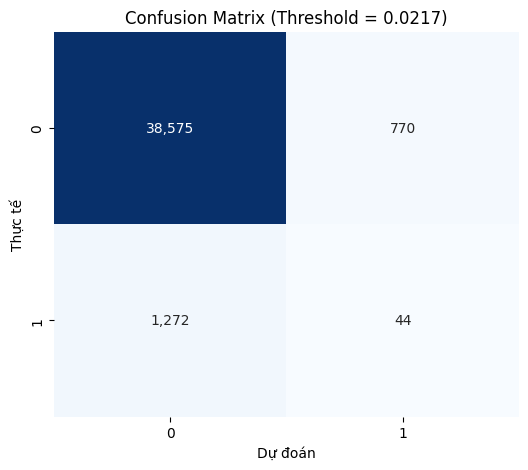

In [93]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Áp dụng ngưỡng Top 1% bạn vừa tìm được
CURRENT_THRESHOLD = threshold
y_pred_new = (mse > CURRENT_THRESHOLD).astype(int)

# 2. In ma trận nhầm lẫn (Confusion Matrix)
cm = confusion_matrix(y_test_synced, y_pred_new)
print("--- MA TRẬN NHẦM LẪN MỚI ---")
print(f"TN (Bình thường đúng): {cm[0][0]:,}")
print(f"FP (Báo động giả):     {cm[0][1]:,}  <-- Mong đợi số này giảm mạnh")
print(f"FN (Bỏ sót gian lận):  {cm[1][0]:,}")
print(f"TP (Bắt đúng gian lận):{cm[1][1]:,}")

# 3. Xem các chỉ số chi tiết
print("\n--- BÁO CÁO CHI TIẾT ---")
print(classification_report(y_test_synced, y_pred_new, digits=4))

# (Tùy chọn) Vẽ ma trận cho dễ nhìn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt=",d", cmap="Blues", cbar=False)
plt.title(f"Confusion Matrix (Threshold = {CURRENT_THRESHOLD:.4f})")
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.show()

In [94]:
import numpy as np
import joblib
import os
from sklearn.metrics import precision_recall_curve, f1_score

# (Đảm bảo bạn đã có 'mse' và 'y_test_synced' từ các bước trước)
# mse = ...
# y_test_synced = ...

print("\n🔄 Đang tìm ngưỡng tối ưu (Best Threshold) bằng Precision-Recall Curve...")

# 1. Sử dụng Precision-Recall Curve để lấy các ngưỡng hiệu quả nhất
# Hàm này tự động chọn các ngưỡng (thresholds) dựa trên các giá trị MSE thực tế
precision, recall, thresholds_pr = precision_recall_curve(y_test_synced, mse)

# 2. Tính F1-score cho TẤT CẢ các ngưỡng được gợi ý
# F1 = 2 * (Precision * Recall) / (Precision + Recall)
# Thêm 1e-10 vào mẫu số để tránh chia cho 0
f1_scores_pr = 2 * (precision * recall) / (precision + recall + 1e-10)

# Lưu ý: precision_recall_curve trả về thresholds ít hơn precision/recall 1 phần tử
# Chúng ta bỏ phần tử cuối cùng của f1, precision, recall để khớp kích thước
f1_scores_pr = f1_scores_pr[:-1]
precision = precision[:-1]
recall = recall[:-1]

# 3. Tìm ngưỡng có F1-Score cao nhất
best_idx = np.argmax(f1_scores_pr)
best_threshold_refined = thresholds_pr[best_idx]

print(f"\n🏆 Đã tìm thấy ngưỡng tối ưu (tinh chỉnh): {best_threshold_refined:.6f}")
print(f"   - F1-Score tại ngưỡng này:  {f1_scores_pr[best_idx]:.4f}")
print(f"   - Precision tại ngưỡng này: {precision[best_idx]:.4f}")
print(f"   - Recall tại ngưỡng này:    {recall[best_idx]:.4f}")

# 4. Lưu ngưỡng MỚI vào file
THRESHOLD_FILE = os.path.join("models", "best_lstm_threshold.pkl")
os.makedirs(os.path.dirname(THRESHOLD_FILE), exist_ok=True)
joblib.dump(best_threshold_refined, THRESHOLD_FILE)
print(f"\n💾 Đã lưu ngưỡng tối ưu TINH CHỈNH vào file: {THRESHOLD_FILE}")

# --- KIỂM TRA NHANH LẠI ---
y_pred_new = (mse > best_threshold_refined).astype(int)
print("\n--- Kiểm tra nhanh kết quả với ngưỡng mới ---")
print(f"Số lượng dự đoán là Gian lận (Mới): {np.sum(y_pred_new)}")
# So sánh với số lượng thực tế nếu có thể
# print(f"Số lượng Gian lận thực tế: {np.sum(y_test_synced)}")


🔄 Đang tìm ngưỡng tối ưu (Best Threshold) bằng Precision-Recall Curve...

🏆 Đã tìm thấy ngưỡng tối ưu (tinh chỉnh): 0.016669
   - F1-Score tại ngưỡng này:  0.0985
   - Precision tại ngưỡng này: 0.0580
   - Recall tại ngưỡng này:    0.3267

💾 Đã lưu ngưỡng tối ưu TINH CHỈNH vào file: models\best_lstm_threshold.pkl

--- Kiểm tra nhanh kết quả với ngưỡng mới ---
Số lượng dự đoán là Gian lận (Mới): 7417


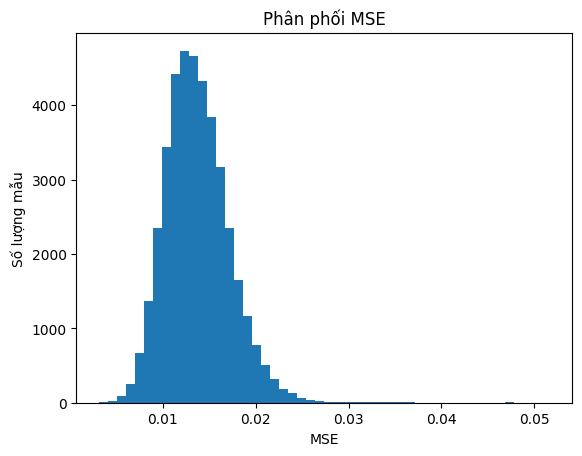

In [95]:
import matplotlib.pyplot as plt

plt.hist(mse, bins=50)
plt.title("Phân phối MSE")
plt.xlabel("MSE")
plt.ylabel("Số lượng mẫu")
plt.show()


In [96]:
import pandas as pd
import numpy as np

print("🕵️ Đang khám nghiệm biến 'mse'...")

# 1. Kiểm tra thống kê cơ bản
print(f"   -> Kiểu dữ liệu: {type(mse)}")
if isinstance(mse, (np.ndarray, pd.Series)):
    print(f"   -> Min MSE: {np.min(mse):.4f}")
    print(f"   -> Max MSE: {np.max(mse):.4f}")
    print(f"   -> Mean MSE: {np.mean(mse):.4f}")
    
    # 2. Kiểm tra xem nó có giống TransactionDT không
    # Lấy một giá trị mẫu
    sample_val = np.median(mse)
    print(f"   -> Giá trị trung vị (Median): {sample_val:.4f}")
    if sample_val > 1e9:
        print("\n⚠️ CẢNH BÁO ĐỎ: Giá trị MSE > 1 tỷ!")
        print("   -> Rất có thể bạn đang dùng nhầm cột TransactionDT làm MSE.")
        print("   -> HOẶC bạn đã quên chuẩn hóa (scale) dữ liệu đầu vào cho Autoencoder.")
else:
    print("⚠️ Biến 'mse' không phải là numpy array hoặc pandas series!")

🕵️ Đang khám nghiệm biến 'mse'...
   -> Kiểu dữ liệu: <class 'numpy.ndarray'>
   -> Min MSE: 0.0031
   -> Max MSE: 0.0517
   -> Mean MSE: 0.0137
   -> Giá trị trung vị (Median): 0.0134


In [97]:
import numpy as np
from sklearn.metrics import precision_recall_curve

# --- Đảm bảo bạn đã có 'mse' và 'y_test_synced' từ các bước trước ---
# Nếu chưa có, hãy chạy lại các bước tạo mse và y_test_synced

print("\n🔄 Đang tính toán lại Precision-Recall Curve...")

# 1. Tính lại đường cong Precision-Recall để đảm bảo biến là array
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_test_synced, mse)

# Loại bỏ phần tử cuối cùng của precision và recall để khớp độ dài với thresholds
precision_curve = precision_curve[:-1]
recall_curve = recall_curve[:-1]

# =========================================
# CÁCH 1: Đặt mục tiêu Precision cụ thể
# =========================================
TARGET_PRECISION = 0.60  # Mục tiêu: 60% (Bạn có thể thử tăng lên 0.7, 0.8 nếu vẫn còn nhiều báo động giả)

print(f"\n🎯 Đang tìm ngưỡng để đạt Precision >= {TARGET_PRECISION*100}%...")

# Tìm các vị trí mà precision đạt mục tiêu
eligible_indices = np.where(precision_curve >= TARGET_PRECISION)[0]

if len(eligible_indices) > 0:
    # Chọn vị trí đầu tiên đạt mục tiêu (ngưỡng thấp nhất thỏa mãn)
    idx_target = eligible_indices[0]
    target_threshold = thresholds_pr[idx_target]

    print(f"✅ Đã tìm thấy ngưỡng phù hợp: {target_threshold:.6f}")
    print(f"   - Precision thực tế: {precision_curve[idx_target]:.4f}")
    print(f"   - Recall tương ứng:  {recall_curve[idx_target]:.4f}")
    
    # Kiểm tra số lượng báo động
    num_alarms = np.sum(mse > target_threshold)
    print(f"   -> Tổng số báo động dự kiến: {num_alarms:,} mẫu")
else:
    print(f"⚠️ Không tìm thấy ngưỡng nào đạt Precision {TARGET_PRECISION*100}%!")
    print("   -> Hãy thử giảm TARGET_PRECISION xuống một chút.")
    # Fallback: Lấy ngưỡng có precision cao nhất
    idx_best_prec = np.argmax(precision_curve)
    print(f"   -> Precision cao nhất có thể đạt được là: {precision_curve[idx_best_prec]:.4f} tại ngưỡng {thresholds_pr[idx_best_prec]:.6f}")


🔄 Đang tính toán lại Precision-Recall Curve...

🎯 Đang tìm ngưỡng để đạt Precision >= 60.0%...
⚠️ Không tìm thấy ngưỡng nào đạt Precision 60.0%!
   -> Hãy thử giảm TARGET_PRECISION xuống một chút.
   -> Precision cao nhất có thể đạt được là: 0.0625 tại ngưỡng 0.036518


In [98]:
import joblib
import os
import numpy as np

# 1. Định nghĩa đường dẫn đến file ngưỡng đã lưu
THRESHOLD_FILE = os.path.join("models", "best_lstm_threshold.pkl")

# 2. Tải ngưỡng từ file
try:
    loaded_threshold = joblib.load(THRESHOLD_FILE)
    print(f"✅ Đã tải ngưỡng thành công: {loaded_threshold:.6f}")
except FileNotFoundError:
    print(f"❌ LỖI: Không tìm thấy file ngưỡng tại '{THRESHOLD_FILE}'")
    # Xử lý lỗi: dừng chương trình hoặc đặt ngưỡng mặc định
    exit()

# --- GIẢ LẬP SỬ DỤNG THỰC TẾ ---
# Giả sử 'new_mse' là lỗi tái tạo của các giao dịch mới cần kiểm tra
# Ví dụ này dùng lại biến 'mse' của bạn để minh họa
if 'mse' in locals():
    new_mse = mse  # Trong thực tế, đây sẽ là MSE của dữ liệu mới
    
    print(f"\n🔍 Đang áp dụng ngưỡng {loaded_threshold:.6f} để phát hiện bất thường...")
    
    # 3. So sánh MSE với ngưỡng để ra quyết định
    # Nếu MSE > ngưỡng -> Bất thường (Gian lận) -> True/1
    # Nếu MSE <= ngưỡng -> Bình thường -> False/0
    is_anomaly = new_mse > loaded_threshold
    
    # Chuyển đổi sang 0 và 1 (tùy chọn, để dễ xử lý sau này)
    predictions = is_anomaly.astype(int)

    # Hiển thị kết quả mẫu
    print(f"Tổng số giao dịch: {len(predictions)}")
    print(f"Số giao dịch bình thường (0): {np.sum(predictions == 0)}")
    print(f"Số giao dịch bất thường (1):  {np.sum(predictions == 1)}")
    
    # Xem thử vài dự đoán đầu tiên
    print("\nDự đoán 10 giao dịch đầu tiên (0=Bình thường, 1=Gian lận):")
    print(predictions[:10])
else:
    print("⚠️ Không có biến 'mse' để test. Hãy đảm bảo bạn đã chạy dự đoán trước đó.")

✅ Đã tải ngưỡng thành công: 0.016669

🔍 Đang áp dụng ngưỡng 0.016669 để phát hiện bất thường...
Tổng số giao dịch: 40661
Số giao dịch bình thường (0): 33244
Số giao dịch bất thường (1):  7417

Dự đoán 10 giao dịch đầu tiên (0=Bình thường, 1=Gian lận):
[0 0 0 0 0 0 0 0 0 0]



📊 ĐÁNH GIÁ HIỆU SUẤT MÔ HÌNH (DỰA TRÊN NGƯỠNG ĐÃ TẢI)
Ngưỡng đang sử dụng: 0.016669

🎯 Accuracy (Độ chính xác tổng thể): 0.8063
🎯 Precision (Độ chính xác dự báo):  0.0578  (Tránh báo động giả)
🎯 Recall (Độ nhạy - Quan trọng!):   0.3260     (Tránh bỏ sót gian lận)
⚖️ F1-Score (Trung bình điều hòa):   0.0982

--- MA TRẬN NHẦM LẪN CHI TIẾT ---
✅ True Negatives (Bình thường đúng):  32,357
❌ False Positives (Báo sai là GL):    6,988
❌ False Negatives (Bỏ sót GL - NGUY HIỂM): 887
✅ True Positives (Bắt đúng GL):       429

📈 ROC-AUC Score: 0.6146
📈 PR-AUC Score:  0.0476 (Ưu tiên cho dữ liệu mất cân bằng)


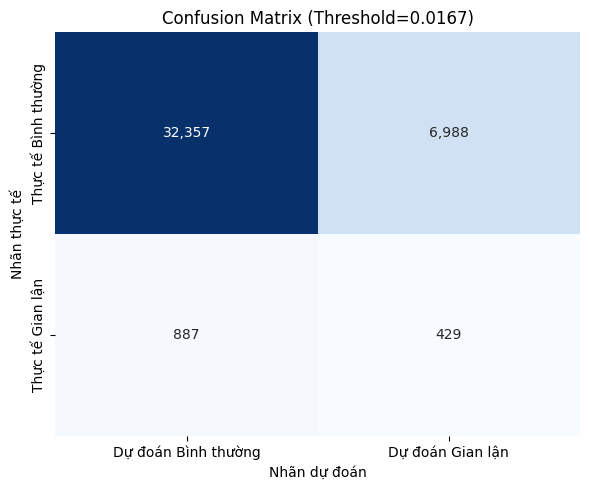


--- BÁO CÁO PHÂN LOẠI ĐẦY ĐỦ ---
                 precision    recall  f1-score   support

Bình thường (0)     0.9733    0.8224    0.8915     39345
   Gian lận (1)     0.0578    0.3260    0.0982      1316

       accuracy                         0.8063     40661
      macro avg     0.5156    0.5742    0.4949     40661
   weighted avg     0.9437    0.8063    0.8658     40661



In [99]:
from sklearn.metrics import (confusion_matrix, classification_report,
                             precision_score, recall_score, f1_score,
                             roc_auc_score, average_precision_score)
import matplotlib.pyplot as plt
import seaborn as sns


if 'predictions' in locals() and 'y_test_synced' in locals():
    print("\n" + "="*40)
    print("📊 ĐÁNH GIÁ HIỆU SUẤT MÔ HÌNH (DỰA TRÊN NGƯỠNG ĐÃ TẢI)")
    print("="*40)

    # 1. Tính các chỉ số chính
    accuracy = np.mean(predictions == y_test_synced)
    precision = precision_score(y_test_synced, predictions, zero_division=0)
    recall = recall_score(y_test_synced, predictions, zero_division=0)
    f1 = f1_score(y_test_synced, predictions, zero_division=0)

    # 2. In ra các chỉ số quan trọng
    print(f"Ngưỡng đang sử dụng: {loaded_threshold:.6f}\n")
    print(f"🎯 Accuracy (Độ chính xác tổng thể): {accuracy:.4f}")
    print(f"🎯 Precision (Độ chính xác dự báo):  {precision:.4f}  (Tránh báo động giả)")
    print(f"🎯 Recall (Độ nhạy - Quan trọng!):   {recall:.4f}     (Tránh bỏ sót gian lận)")
    print(f"⚖️ F1-Score (Trung bình điều hòa):   {f1:.4f}")

    # 3. Ma trận nhầm lẫn (Confusion Matrix)
    cm = confusion_matrix(y_test_synced, predictions)
    tn, fp, fn, tp = cm.ravel()

    print("\n--- MA TRẬN NHẦM LẪN CHI TIẾT ---")
    print(f"✅ True Negatives (Bình thường đúng):  {tn:,}")
    print(f"❌ False Positives (Báo sai là GL):    {fp:,}")
    print(f"❌ False Negatives (Bỏ sót GL - NGUY HIỂM): {fn:,}")
    print(f"✅ True Positives (Bắt đúng GL):       {tp:,}")

    # 4. (Tùy chọn) Các chỉ số nâng cao nếu có 'mse' gốc
    if 'mse' in locals():
        roc_auc = roc_auc_score(y_test_synced, mse)
        pr_auc = average_precision_score(y_test_synced, mse)
        print(f"\n📈 ROC-AUC Score: {roc_auc:.4f}")
        print(f"📈 PR-AUC Score:  {pr_auc:.4f} (Ưu tiên cho dữ liệu mất cân bằng)")

    # 5. Vẽ Confusion Matrix trực quan
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt=',d', cmap='Blues', cbar=False,
                xticklabels=['Dự đoán Bình thường', 'Dự đoán Gian lận'],
                yticklabels=['Thực tế Bình thường', 'Thực tế Gian lận'])
    plt.title(f'Confusion Matrix (Threshold={loaded_threshold:.4f})')
    plt.ylabel('Nhãn thực tế')
    plt.xlabel('Nhãn dự đoán')
    plt.tight_layout()
    plt.show()

    # 6. Báo cáo phân loại đầy đủ
    print("\n--- BÁO CÁO PHÂN LOẠI ĐẦY ĐỦ ---")
    print(classification_report(y_test_synced, predictions, target_names=['Bình thường (0)', 'Gian lận (1)'], digits=4))

else:
    print("⚠️ Không đủ dữ liệu để đánh giá. Cần có 'predictions' và 'y_test_synced'.")


📈 VẼ BIỂU ĐỒ PRECISION-RECALL CURVE
🌟 Average Precision (PR-AUC): 0.0476


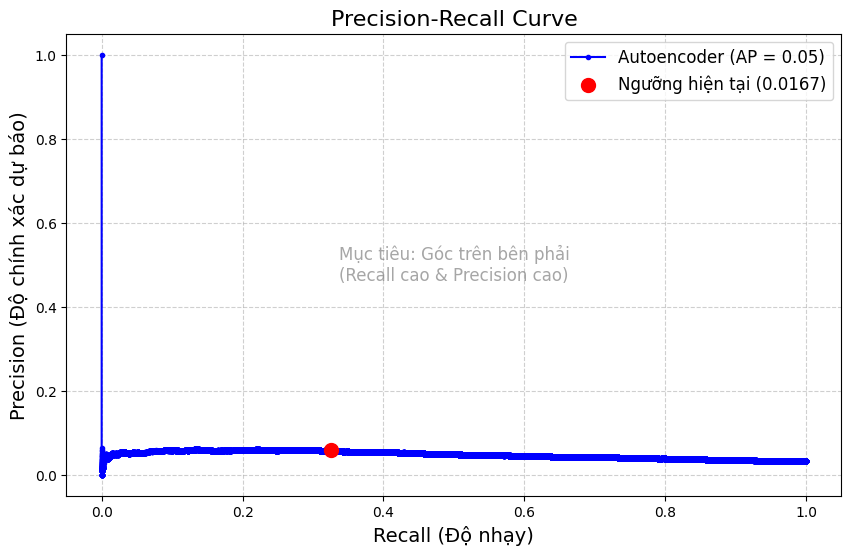


💡 GỢI Ý TỪ BIỂU ĐỒ:
   Ngưỡng cho F1-Score cao nhất có thể là: 0.016669
   (Tại ngưỡng đó: Precision ~ 0.0580, Recall ~ 0.3267)


In [100]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Kiểm tra xem các biến cần thiết có tồn tại không
if 'mse' in locals() and 'y_test_synced' in locals():
    print("\n" + "="*40)
    print("📈 VẼ BIỂU ĐỒ PRECISION-RECALL CURVE")
    print("="*40)

    # 1. Tính toán Precision, Recall cho các ngưỡng khác nhau
    precision_vals, recall_vals, thresholds = precision_recall_curve(y_test_synced, mse)

    # 2. Tính diện tích dưới đường cong PR (Average Precision)
    avg_precision = average_precision_score(y_test_synced, mse)
    print(f"🌟 Average Precision (PR-AUC): {avg_precision:.4f}")

    # 3. Vẽ biểu đồ
    plt.figure(figsize=(10, 6))
    plt.plot(recall_vals, precision_vals, marker='.', label=f'Autoencoder (AP = {avg_precision:.2f})', color='b')

    # --- Điểm hiện tại ---
    # Tính Precision/Recall tại ngưỡng hiện tại để đánh dấu trên biểu đồ
    current_precision = precision_score(y_test_synced, predictions, zero_division=0)
    current_recall = recall_score(y_test_synced, predictions, zero_division=0)

    plt.scatter(current_recall, current_precision, color='red', s=100, zorder=5,
                label=f'Ngưỡng hiện tại ({loaded_threshold:.4f})')

    # Trang trí biểu đồ
    plt.title('Precision-Recall Curve', fontsize=16)
    plt.xlabel('Recall (Độ nhạy)', fontsize=14)
    plt.ylabel('Precision (Độ chính xác dự báo)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12)

    # Thêm chú thích để dễ hiểu hơn
    plt.text(0.5, 0.5, 'Mục tiêu: Góc trên bên phải\n(Recall cao & Precision cao)',
             fontsize=12, color='gray', alpha=0.7, ha='center', va='center', transform=plt.gca().transAxes)

    plt.show()

    # --- Gợi ý thêm: Tìm ngưỡng tối ưu dựa trên F1-Score ---
    # Tính F1-score cho tất cả các ngưỡng
    f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-10) # Thêm 1e-10 để tránh chia cho 0
    # Tìm vị trí của F1-score lớn nhất
    best_idx = np.argmax(f1_scores)
    best_threshold_f1 = thresholds[best_idx] if best_idx < len(thresholds) else thresholds[-1]

    print("\n💡 GỢI Ý TỪ BIỂU ĐỒ:")
    print(f"   Ngưỡng cho F1-Score cao nhất có thể là: {best_threshold_f1:.6f}")
    print(f"   (Tại ngưỡng đó: Precision ~ {precision_vals[best_idx]:.4f}, Recall ~ {recall_vals[best_idx]:.4f})")

else:
    print("⚠️ Không đủ dữ liệu để vẽ PR Curve. Cần có 'mse' (điểm số lỗi) và 'y_test_synced' (nhãn thực).")